In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math
import optuna
import shap

from catboost import CatBoostRegressor

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


d:\01 Professional software operation\minicondaa\envs\wone\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

folder_path = 'AD-figure'

# 检查文件夹是否存在，如果不存在则创建它
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    print(f"文件夹 {folder_path} 已创建。")

In [3]:
# 读取数据，设置指定列的类型
df = pd.read_csv("ADlog_填充.csv",  dtype={'DIPOCE': str, 'BA_Code': str, 'Cata_Code': str})
df

,DIPOCE,DI_NCO,PO_HV,PO_f,BA_Code,BA_Mn,PO_Phr,BA_Phr,FS_Phr,Cata_Phr,...,M_loss,Yield,R,CHS,A_Mix_T,AB_Mix_T,Q,Cata_Code,MCS,AD(kg/m3)
0,0110100000,31.0,367.991736,4.464132,1000,18.0,67.567568,2.182432,1.013514,1.013514,...,5.351351,96.884711,1.83,59.700000,81.11,5.3,0.0,100000,108.6000,36.8
1,0110100000,31.0,367.991736,4.464132,1000,18.0,67.567568,2.182432,1.013514,1.013514,...,5.351351,96.884711,1.83,59.700000,81.11,5.3,0.0,100000,94.1000,36.8
2,0100010000,31.5,440.000000,3.158698,1000,18.0,50.676157,1.494662,1.010676,0.455516,...,5.229893,97.017857,1.10,58.400000,120.00,10.0,0.0,100100,310.0000,39.0
3,0100100100,31.5,429.326712,3.370281,1000,18.0,32.931727,0.975330,0.659782,0.295468,...,4.215720,97.377587,1.10,63.500000,120.00,10.0,0.0,100100,220.0000,37.6
4,0100100100,31.5,418.118624,3.432704,1000,18.0,30.906059,0.990550,0.617009,0.278488,...,4.084491,97.428971,1.10,64.600000,120.00,10.0,0.0,100100,210.0000,30.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
288,0100010000,31.0,416.000000,2.000000,1000,18.0,73.421439,2.276065,1.101322,0.367107,...,5.563713,96.859603,1.10,57.662997,103.59,5.0,48.0,100000,219.2185,37.8
289,0100010000,31.0,416.000000,2.000000,1000,18.0,80.515298,1.328502,1.207729,0.402576,...,3.247450,98.229830,1.10,55.396967,125.04,5.0,48.0,100000,217.1510,58.0
290,0100010000,31.0,416.000000,2.000000,1000,18.0,84.104289,0.849453,1.261564,0.420521,...,2.076441,98.887437,1.10,54.317040,119.34,5.0,48.0,100000,211.3560,81.3
291,0100010000,31.0,416.000000,2.000000,1000,18.0,85.251492,0.699062,1.278772,0.426257,...,1.708819,99.089386,1.10,53.980672,117.65,5.0,48.0,100000,202.5670,97.6


In [4]:
y = np.log10(df['AD(kg/m3)'])
X = df.drop(["AD(kg/m3)"], axis=1)
X

,DIPOCE,DI_NCO,PO_HV,PO_f,BA_Code,BA_Mn,PO_Phr,BA_Phr,FS_Phr,Cata_Phr,C_BA_MR,M_loss,Yield,R,CHS,A_Mix_T,AB_Mix_T,Q,Cata_Code,MCS
0,0110100000,31.0,367.991736,4.464132,1000,18.0,67.567568,2.182432,1.013514,1.013514,0.180000,5.351351,96.884711,1.83,59.700000,81.11,5.3,0.0,100000,108.6000
1,0110100000,31.0,367.991736,4.464132,1000,18.0,67.567568,2.182432,1.013514,1.013514,0.180000,5.351351,96.884711,1.83,59.700000,81.11,5.3,0.0,100000,94.1000
2,0100010000,31.5,440.000000,3.158698,1000,18.0,50.676157,1.494662,1.010676,0.455516,0.167000,5.229893,97.017857,1.10,58.400000,120.00,10.0,0.0,100100,310.0000
3,0100100100,31.5,429.326712,3.370281,1000,18.0,32.931727,0.975330,0.659782,0.295468,0.167000,4.215720,97.377587,1.10,63.500000,120.00,10.0,0.0,100100,220.0000
4,0100100100,31.5,418.118624,3.432704,1000,18.0,30.906059,0.990550,0.617009,0.278488,0.167000,4.084491,97.428971,1.10,64.600000,120.00,10.0,0.0,100100,210.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
288,0100010000,31.0,416.000000,2.000000,1000,18.0,73.421439,2.276065,1.101322,0.367107,0.172222,5.563713,96.859603,1.10,57.662997,103.59,5.0,48.0,100000,219.2185
289,0100010000,31.0,416.000000,2.000000,1000,18.0,80.515298,1.328502,1.207729,0.402576,0.091667,3.247450,98.229830,1.10,55.396967,125.04,5.0,48.0,100000,217.1510
290,0100010000,31.0,416.000000,2.000000,1000,18.0,84.104289,0.849453,1.261564,0.420521,0.056111,2.076441,98.887437,1.10,54.317040,119.34,5.0,48.0,100000,211.3560
291,0100010000,31.0,416.000000,2.000000,1000,18.0,85.251492,0.699062,1.278772,0.426257,0.045556,1.708819,99.089386,1.10,53.980672,117.65,5.0,48.0,100000,202.5670


In [5]:
params = {'iterations':1400,
            'depth': 6,
            'learning_rate': 0.012,
            'l2_leaf_reg': 2.8,
            'bagging_temperature': 0.43,
            'border_count': 178,
      }

In [6]:
# 定义 RSE 计算函数
def calculate_rse(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_mean = np.mean(y_true)
    numerator = np.sum((y_true - y_pred) ** 2)
    denominator = np.sum((y_true - y_mean) ** 2)
    rse = np.sqrt(numerator / denominator) if denominator != 0 else np.nan
    return rse

# 定义评估函数
def evaluate_model(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = math.sqrt(mse)
    rse = calculate_rse(y_true, y_pred)
    return r2, mae, mse, rmse, rse

# 设置随机种子范围
random_seeds = range(0, 100)

# 评估结果列表
scores = []

# 多种子 5 折交叉验证
for seed in random_seeds:
    print(f"Evaluating with Random Seed: {seed}")
    kf = KFold(n_splits=3, shuffle=True, random_state=seed)

    for fold_idx, (train_idx, test_idx) in enumerate(kf.split(X), 1):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model = CatBoostRegressor(**params, random_seed=seed, verbose=0)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        r2, mae, mse, rmse, rse = evaluate_model(y_test, y_pred)

        scores.append({
            "Seed": seed,
            "Fold": fold_idx,
            "R²": r2,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "RSE": rse
        })

# 转换为 DataFrame
score_df1 = pd.DataFrame(scores)


Evaluating with Random Seed: 0
Evaluating with Random Seed: 1
Evaluating with Random Seed: 2
Evaluating with Random Seed: 3
Evaluating with Random Seed: 4
Evaluating with Random Seed: 5
Evaluating with Random Seed: 6
Evaluating with Random Seed: 7
Evaluating with Random Seed: 8
Evaluating with Random Seed: 9
Evaluating with Random Seed: 10
Evaluating with Random Seed: 11
Evaluating with Random Seed: 12
Evaluating with Random Seed: 13
Evaluating with Random Seed: 14
Evaluating with Random Seed: 15
Evaluating with Random Seed: 16
Evaluating with Random Seed: 17
Evaluating with Random Seed: 18
Evaluating with Random Seed: 19
Evaluating with Random Seed: 20
Evaluating with Random Seed: 21
Evaluating with Random Seed: 22
Evaluating with Random Seed: 23
Evaluating with Random Seed: 24
Evaluating with Random Seed: 25
Evaluating with Random Seed: 26
Evaluating with Random Seed: 27
Evaluating with Random Seed: 28
Evaluating with Random Seed: 29
Evaluating with Random Seed: 30
Evaluating with Ra

In [7]:
# 计算每个种子的 R² 方差
r2_var_by_seed = score_df1.groupby("Seed")["R²"].var(ddof=1).reset_index()
r2_var_by_seed.columns = ["Seed", "R2_Variance"]
r2_var_sorted = r2_var_by_seed.sort_values(by="R2_Variance")

# 输出最稳定与最不稳定的种子，根据方差
print("🎯 最稳定的5个种子：")
print(r2_var_sorted.head())

print("\n⚠️ 最不稳定的5个种子：")
print(r2_var_sorted.tail())


🎯 最稳定的5个种子：
    Seed  R2_Variance
59    59     0.000021
24    24     0.000051
27    27     0.000085
13    13     0.000103
34    34     0.000163

⚠️ 最不稳定的5个种子：
    Seed  R2_Variance
38    38     0.013430
61    61     0.014919
80    80     0.014978
96    96     0.017791
89    89     0.025887


C:\Users\Administrator\AppData\Local\Temp\ipykernel_27016\1768623106.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Seed', y='R2_Variance', data=r2_var_sorted, palette='viridis')


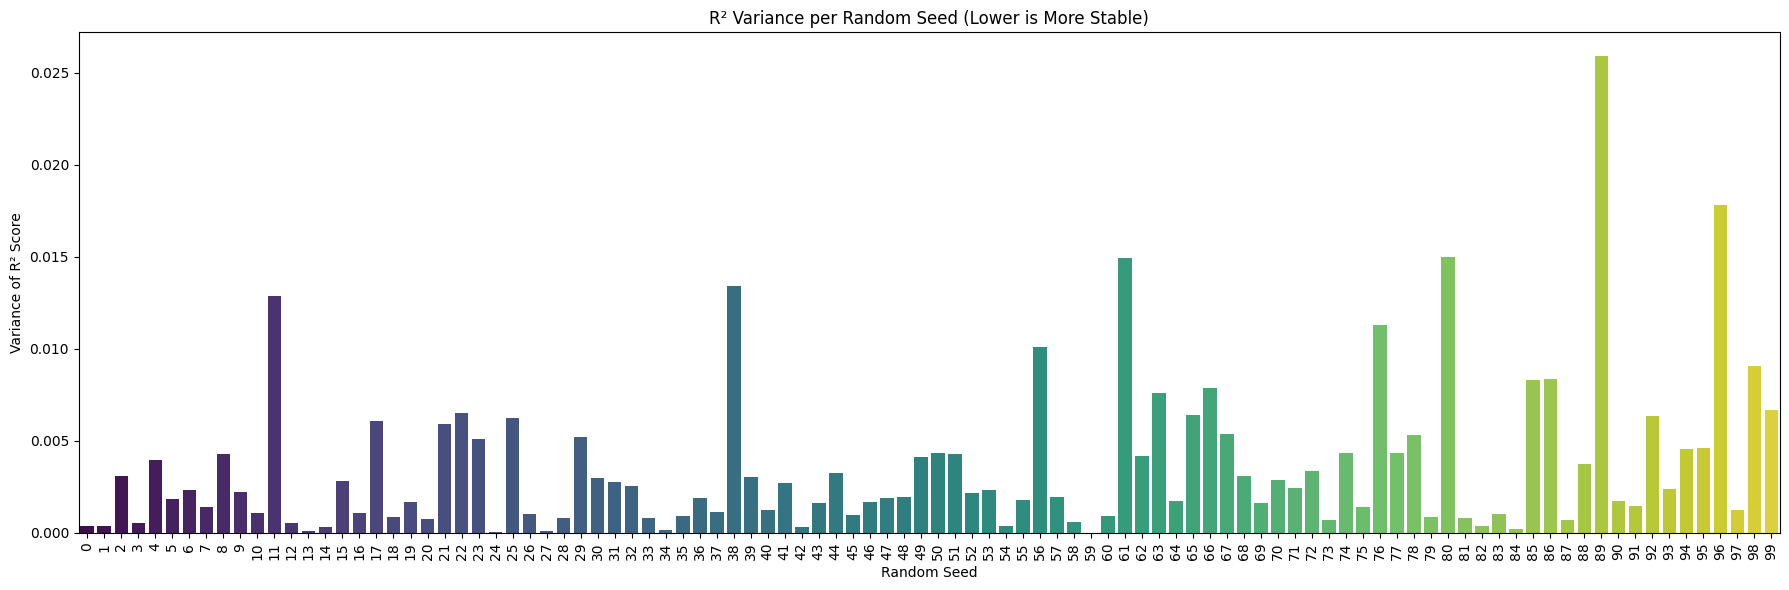

In [8]:
# 绘制种子方差柱状图
plt.figure(figsize=(18, 6))
sns.barplot(x='Seed', y='R2_Variance', data=r2_var_sorted, palette='viridis')
plt.title('R² Variance per Random Seed (Lower is More Stable)')
plt.xlabel('Random Seed')
plt.ylabel('Variance of R² Score')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [9]:
score_df1

,Seed,Fold,R²,MAE,MSE,RMSE,RSE
0,0,1,0.748578,0.052884,0.006148,0.078410,0.501420
1,0,2,0.784877,0.057385,0.007306,0.085478,0.463814
2,0,3,0.752865,0.053617,0.008173,0.090405,0.497126
3,1,1,0.847318,0.046571,0.004698,0.068541,0.390746
4,1,2,0.811092,0.045902,0.006022,0.077602,0.434635
...,...,...,...,...,...,...,...
295,98,2,0.803337,0.049330,0.006050,0.077784,0.443467
296,98,3,0.804796,0.048737,0.005161,0.071839,0.441820
297,99,1,0.795942,0.057261,0.006547,0.080917,0.451728
298,99,2,0.858421,0.043686,0.004558,0.067516,0.376270


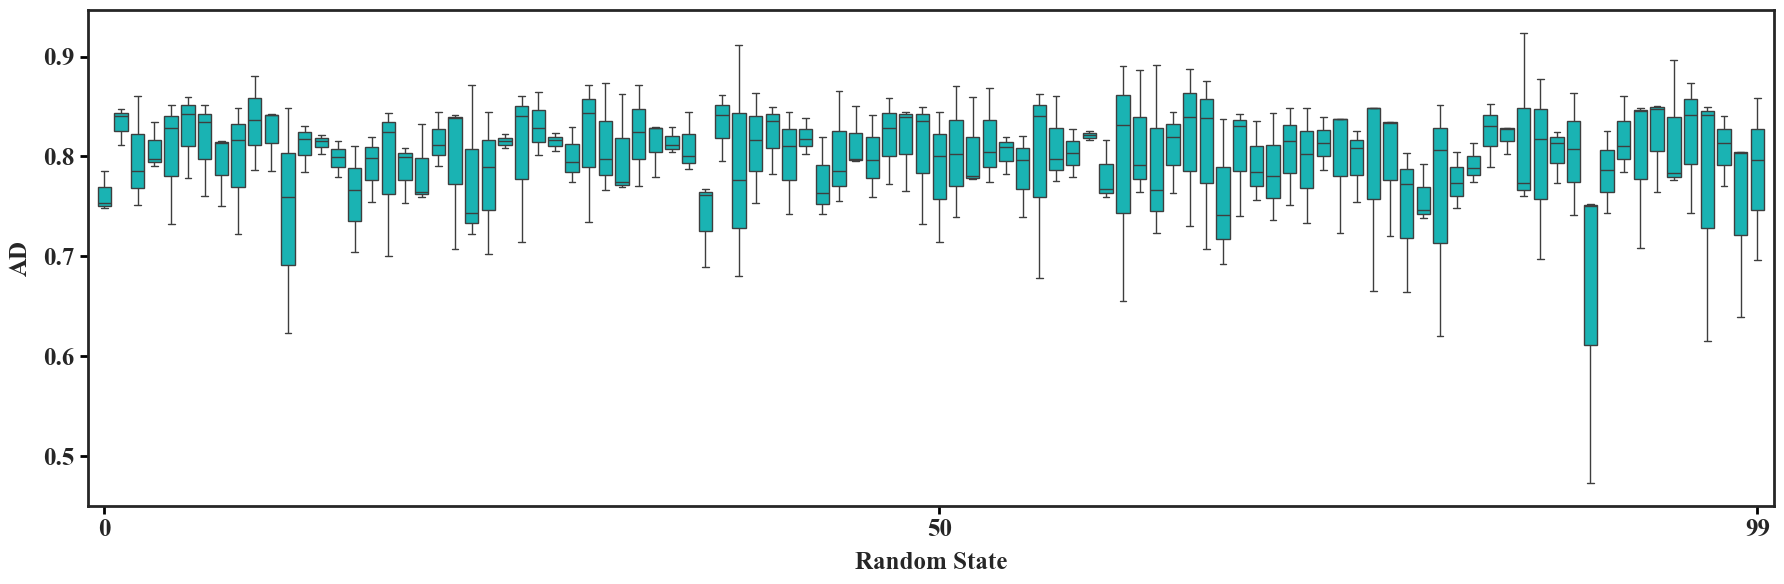

In [10]:
plt.figure(figsize=(18, 6))
sns.set(style="white", palette="muted", font_scale=1)

sns.boxplot(x='Seed', y='R²', data=score_df1, color='#00CDCD', linewidth=1, width=0.8, fliersize=5 )

# 设置横坐标仅显示特定的种子编号
plt.xticks(ticks=[0, 50, 99], labels=['0', '50', '99'], fontsize=18, fontname='Times New Roman', weight='bold')
plt.xlim(-1, 100)  # 设置x轴范围
plt.yticks(fontsize=18, fontname='Times New Roman', weight='bold')
plt.tick_params(axis='both', which='both', direction='out', length=6, width=2, color='black', bottom=True, top=False, left=True, right=False)

# 设置标题和标签
plt.xlabel('Random State', fontsize=18, fontname='Times New Roman', weight='bold',labelpad=8)
plt.ylabel('AD', fontsize=18, fontname='Times New Roman', weight='bold',labelpad=8)

# 设置边框粗细，比如加粗到2
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(2)

# 去除顶部和右侧边框
# sns.despine()

plt.tight_layout()
plt.show()


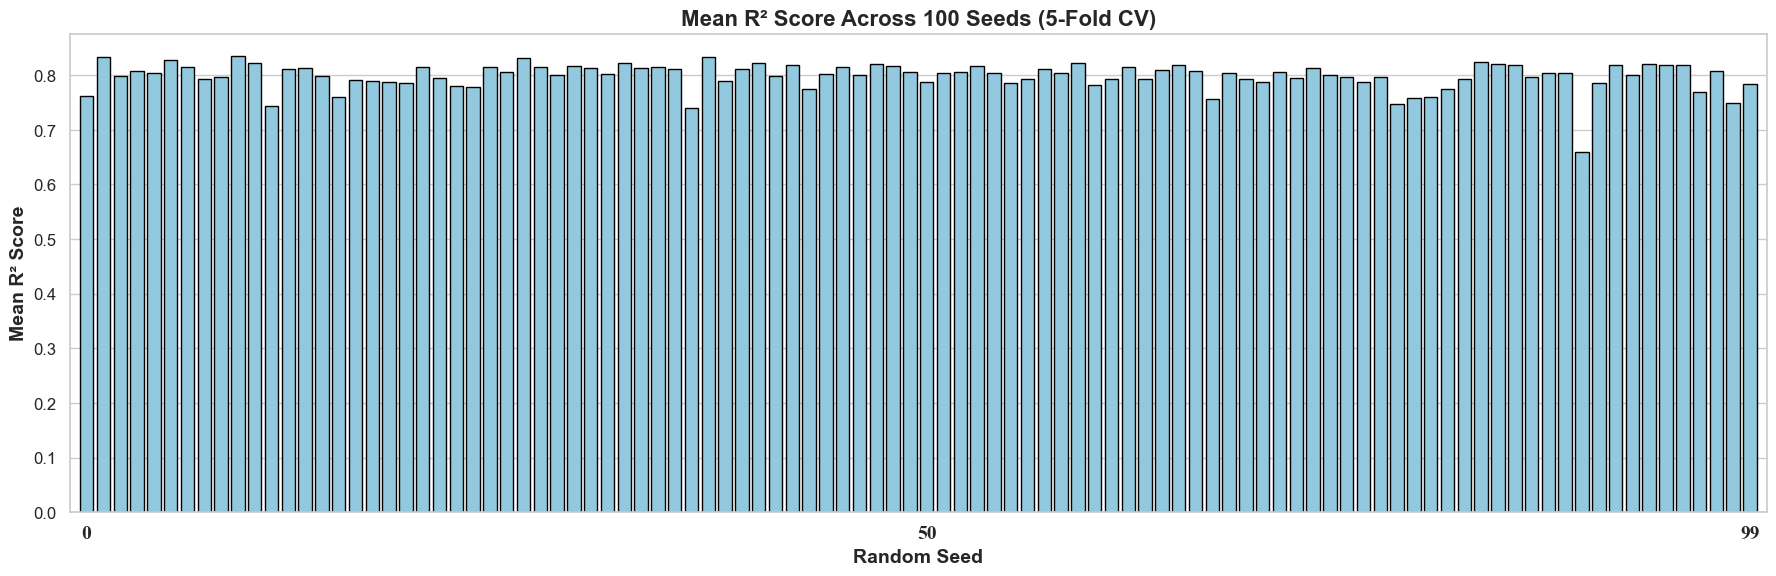

In [11]:
# 计算每个种子的平均 R² 值
mean_r2_df = score_df1.groupby('Seed', as_index=False)['R²'].mean()

# 设置绘图风格
sns.set(style="whitegrid", font_scale=1.2)

# 创建柱状图
plt.figure(figsize=(18, 6))
sns.barplot(x='Seed', y='R²', data=mean_r2_df, color='skyblue', edgecolor='black')

# 设置坐标轴范围和刻度
plt.xlim(-1, 100)
plt.xticks(ticks=[0, 50, 99],  labels=['0', '50', '99'],  fontsize=14,  fontname='Times New Roman',  weight='bold')
plt.yticks(fontsize=12)

# 设置标题和轴标签
plt.title('Mean R² Score Across 100 Seeds (5-Fold CV)', fontsize=16, fontweight='bold')
plt.xlabel('Random Seed', fontsize=14, fontweight='bold')
plt.ylabel('Mean R² Score', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()


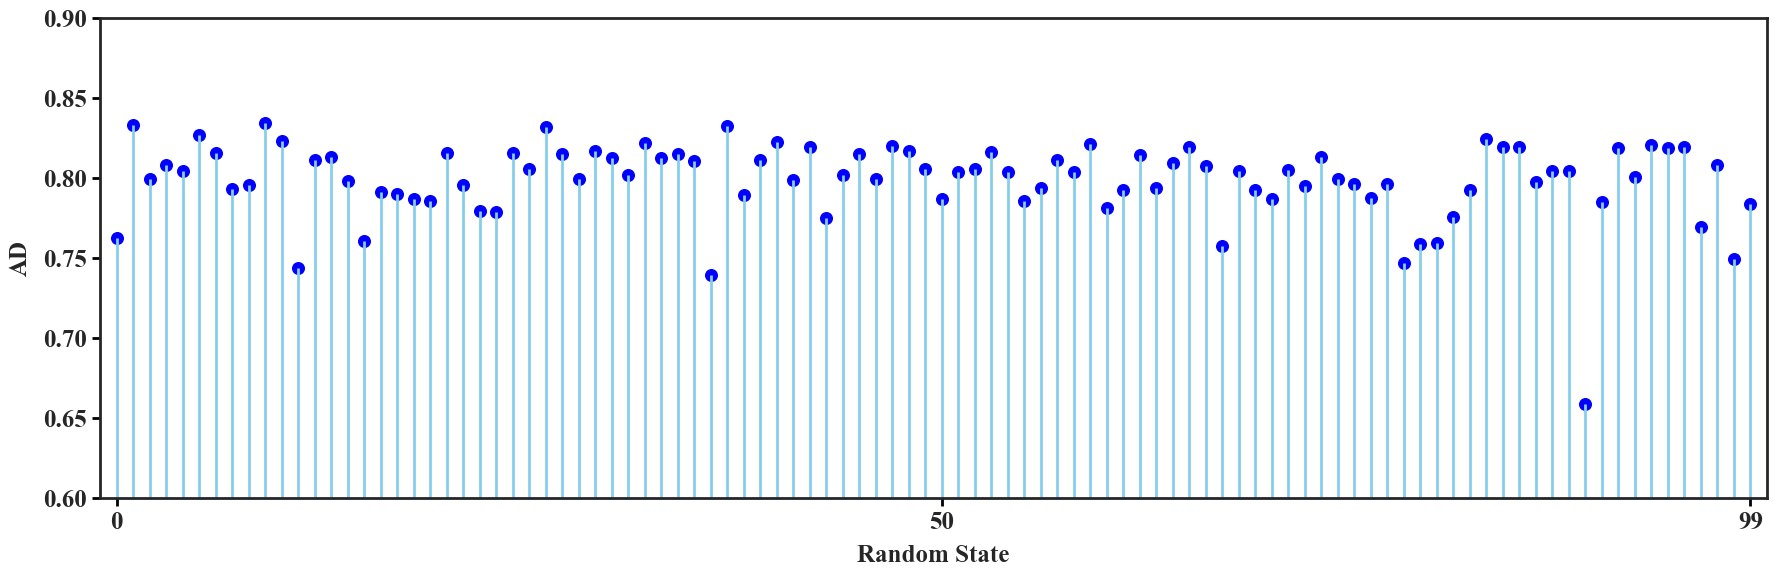

In [12]:
# 设置绘图风格
sns.set(style="white", font_scale=1.2)

# 创建棒棒糖图
plt.figure(figsize=(18, 6))

# 画线（棒棒糖杆） -> 垂直线，从 y=0 到 y=R2
plt.vlines(x=mean_r2_df['Seed'], ymin=0, ymax=mean_r2_df['R²'], color='skyblue', linewidth=2)

# 画点（棒棒糖头）
plt.scatter(mean_r2_df['Seed'], mean_r2_df['R²'], color='blue', s=70)

# 设置横坐标范围和刻度
plt.xticks(ticks=[0, 50, 99], labels=['0', '50', '99'], fontsize=18, fontname='Times New Roman', weight='bold')
plt.xlim(-1, 100)
plt.ylim(0.6, 0.9) # 设置x轴范围
plt.yticks(fontsize=18, fontname='Times New Roman', weight='bold')
plt.tick_params(axis='both', which='both', direction='out', length=6, width=2, color='black', bottom=True, top=False, left=True, right=False)

# 设置标题和标签
plt.xlabel('Random State', fontsize=18, fontname='Times New Roman', weight='bold',labelpad=8)
plt.ylabel('AD', fontsize=18, fontname='Times New Roman', weight='bold',labelpad=8)

# 设置边框粗细，比如加粗到2
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(2)
# 去除顶部和右侧边框
# sns.despine()
plt.tight_layout()
plt.show()

In [13]:
score_df1.insert(0, 'Feature', 'AD')  
score_df1.to_csv('AD-平行实验-3.csv', index=False)
